In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import table
from astropy.table import Table
from astropy.io import ascii
import matplotlib.ticker as ticker

from astroML.plotting import scatter_contour

SAGA_DIR = os.environ['SAGA_DIR']


In [29]:
from palettable.colorbrewer.qualitative import Dark2_8
if 'plt' in locals() and hasattr(plt, 'rcParams'):
    plt.rcParams['lines.linewidth'] = 2.0
    plt.rcParams['font.size'] = 15.0
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Dark2_8.mpl_colors)
    plt.rcParams['legend.fontsize'] = 'medium'
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = 7, 8
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 4
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 4

In [30]:
# READ SPECTRA
file = SAGA_DIR +'/data/saga_spectra_clean.fits.gz'
allspec = Table.read(file)

In [31]:
#msk          = allspec['HOST_SAGA_NAME'] != '' 
#allspec=allspec[msk]

In [32]:
# FIND GOOD OBJECTS 
m_rmv  = allspec['REMOVE'] == -1
m_fib  = allspec['FIBERMAG_R'] <= 23
m_gal  = allspec['PHOT_SG'] == 'GALAXY'

m_boss = allspec['survey'] != 'boss'

spec=allspec[m_rmv & m_fib & m_gal &m_boss]

In [33]:
# EXPLORE BRIGHT AND FAINT GALAXIES SEPARATELY
m_f1 = (spec['r'] - spec['EXTINCTION_R']) >17.7
m_f2 = (spec['r'] - spec['EXTINCTION_R']) <=20.75
m_f  = m_f1 & m_f2 
m_b1  = (spec['r'] - spec['EXTINCTION_R']) < 17.7
m_b2  = (spec['r'] - spec['EXTINCTION_R']) > 15
m_b=m_b1& m_b2

sats = spec['SATS'] == 1
lowz = (spec['SPEC_Z'] > 0.005) & (spec['SPEC_Z'] < 0.015)

print np.sum(sats)
print np.sum(lowz)


167
390


In [34]:
# MAKE COLORS
gmag = spec['g'] - spec['EXTINCTION_G']
rmag = spec['r'] - spec['EXTINCTION_R']
imag = spec['i'] - spec['EXTINCTION_I']

gr = gmag - rmag
ri = rmag - imag

In [35]:
# SET PLOT LIMITS
xl = [-0.3,1.7]
yl=[-0.55,1.1]

xl1 = gr > xl[0]
xl2 = gr < xl[1]
yl1 = ri > yl[0]
yl2 = ri < yl[1]
lims = xl1&xl2&yl1&yl2

tgr = 0.85
tri = 0.55

In [36]:
# MODEL GALAXIES

#model = ascii.read(SAGA_DIR+'/cats/gal_r20.75_Mr_16_11_sftag.txt')
model = ascii.read('/Users/marlageha/Projects/SAGA/data/gal_r20.75_Mr_16_11_sftag_witherr.txt')

m=(model['e_g'] < 0.1)&(model['e_r'] < 0.1)&(model['e_i'] < 0.1)
model=model[m]

model_gr = model['g'] - model['r']
model_ri = model['r'] - model['i']
sf = model['Tag_SF'] == 1
abs = model['Tag_SF'] == 0
model.columns

print np.sum(sf),np.sum(abs)

grerr = np.sqrt(model['e_g']**2 + model['e_r']**2)
rierr = np.sqrt(model['e_r']**2 + model['e_i']**2)

model_cgr = model_gr - 2.*grerr
model_cri = model_ri - 2.*rierr

tgr = 0.85
tri=0.55
msk1 = model_cgr > tgr
msk2 = model_cri >tri
m1 = model_gr >tgr
m2 = model_ri > tri
print np.sum(msk1 | msk2),np.sum(m1 | m2)
    
#for obj in model[m1 | m2]:
#    print obj['e_g'],obj['e_r'],obj['e_i']

1830 118062
0 31


(array([ 116.,  104.,   99.,   92.,   99.,   94.,   73.,   89.,   71.,
          82.,   67.,   84.,   74.,   55.,   70.,   59.,   69.,   70.,
          64.,   72.,   54.,   52.,   51.,   44.,   26.]),
 array([ 17.1567  ,  17.299932,  17.443164,  17.586396,  17.729628,
         17.87286 ,  18.016092,  18.159324,  18.302556,  18.445788,
         18.58902 ,  18.732252,  18.875484,  19.018716,  19.161948,
         19.30518 ,  19.448412,  19.591644,  19.734876,  19.878108,
         20.02134 ,  20.164572,  20.307804,  20.451036,  20.594268,  20.7375  ]),
 <a list of 25 Patch objects>)

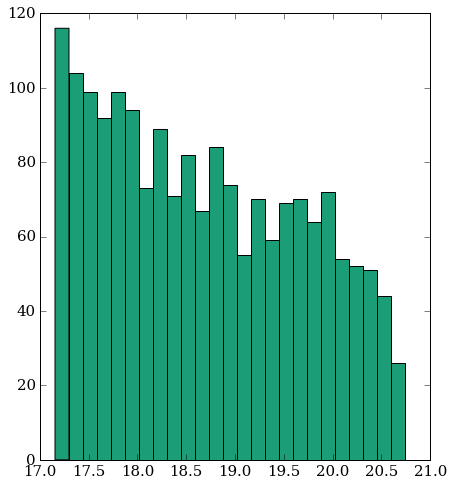

In [37]:
# HOW MUCH FAINTER ARE QUENCHED MODEL GALAXIES?
#plt.hist(model['r'][abs],bins=25)
plt.hist(model['r'][sf],bins=25)

0
Bright lowz =  205
Bright sats =  92
Faint lowz =  34
Faint sats =  18


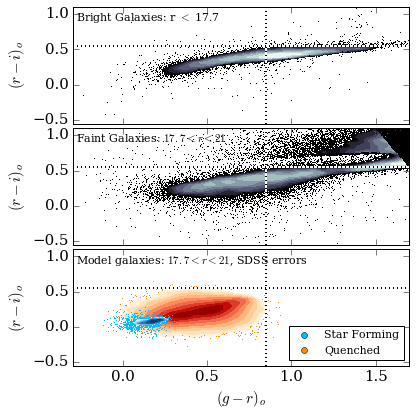

In [44]:
# MAKE SCATTER PLOTS
fig, (ax1, ax2,ax3) = plt.subplots(3, 1)

scatter_contour(gr[m_b&lims], ri[m_b&lims], ax=ax1,
                threshold=30, log_counts=True, 
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

add_outlier_errors(spec[m_b & lowz],ax1)

ax1.plot(gr[m_b & sats], ri[m_b & sats],'ro',zorder=4,label='SDSS-SAGA sats')
ax1.plot(gr[m_b & lowz&~sats], ri[m_b & lowz&~sats],'bs',zorder=3,label = '0.005$<$z$<$0.015')

print 'Bright lowz = ',np.sum(m_b & lowz)
print 'Bright sats = ',np.sum(m_b & sats)

ax1.set_xlim(xl)
ax1.set_ylim(yl)
ax1.text(xl[0]+0.02,yl[1]-0.2,'Bright Galaxies: r $<$ 17.7',fontsize=11)
ax1.get_xaxis().set_ticklabels([])
ax1.axvline(tgr, c='w')
ax1.axvline(tgr, c='k', ls=':')
ax1.axhline(tri, c='w')
ax1.axhline(tri, c='k', ls=':')
ax1.set_ylabel('$(r-i)_o$')



# CMASS/BOSS
gr_cmass1 = np.arange(1,2.5,0.1)
gr_cmass2 = np.arange(0,1.2,0.1)
gr_cmass3 = gr_cmass1+10

ri_lowz_p = 0.2+(gr_cmass1)/4. +0.18
ri_lowz_perp = (1.26 - 0.7*gr_cmass2)/1.2 +0.18
ri_cmass = 0.55 + gr_cmass1/8.
#ax1.plot(gr_cmass3,ri_cmass,'g',label='SDSS BOSS')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

ax1.legend(loc=4,fontsize=10,frameon=True,numpoints = 1)

####################################
scatter_contour(gr[m_f&lims], ri[m_f&lims], ax=ax2,
                threshold=50, log_counts=True, 
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

#add_outlier_errors(spec[m_f & lowz],ax2)
print 'Faint lowz = ',np.sum(m_f & lowz)
print 'Faint sats = ',np.sum(m_f & sats)

ax2.plot(gr[m_f & sats], ri[m_f & sats],'ro',zorder=4,label = 'SAGA satellites')
ax2.plot(gr[m_f & lowz&~sats], ri[m_f & lowz&~sats],'bs',zorder=3,label = '0.005$<$z$<$0.015')

ax2.legend(loc=4,fontsize=10,frameon=True,numpoints = 1)

ax2.set_xlim(xl)
ax2.set_ylim(yl)
ax2.text(xl[0]+0.02,yl[1]-0.2,'Faint Galaxies: $17.7 < r < 21$',fontsize=11)
ax2.axvline(tgr, c='w')
ax2.axvline(tgr, c='k', ls=':')
ax2.axhline(tri, c='w')
ax2.axhline(tri, c='k', ls=':')
#plt.legend(loc=4,fontsize=9)
ax2.set_ylabel('$(r-i)_o$')

ax2.get_xaxis().set_ticklabels([])
ax3.set_xlabel('$(g-r)_o$')

ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))



# MODELS
###################################### 
mxl1 = model_gr > xl[0]
mxl2 = model_gr < xl[1]
myl1 = model_ri > yl[0]
myl2 = model_ri < yl[1]
mlims = mxl1&mxl2&myl1&myl2

scatter_contour(model_gr[abs&mlims], model_ri[abs&mlims], ax=ax3,
                threshold=6, log_counts=True, 
                histogram2d_args=dict(bins=20),
                plot_args=dict(marker=',', linestyle='none', color='#ff8c00'),
                contour_args=dict(cmap=plt.cm.OrRd))

scatter_contour(model_gr[sf&mlims], model_ri[sf&mlims], ax=ax3,
                threshold=16, log_counts=True, 
                histogram2d_args=dict(bins=20),
                plot_args=dict(marker=',', linestyle='none', color='#00bfff'),
                contour_args=dict(cmap=plt.cm.Blues))

#add_outlier_errors(spec[m_b & lowz],ax1)

ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

ax3.set_xlim(xl)
ax3.set_ylim(yl)
ax3.text(xl[0]+0.02,yl[1]-0.2,'Model galaxies: $17.7 < r < 21$, SDSS errors',fontsize=11)
ax3.axvline(tgr, c='w')
ax3.axvline(tgr, c='k', ls=':')
ax3.axhline(tri, c='w')
ax3.axhline(tri, c='k', ls=':')
ax3.set_ylabel('$(r-i)_o$')


ax3.plot([-99],[-99],'o',color= '#00bfff',label='Star Forming')
ax3.plot([-99],[-99],'o',color= '#ff8c00',label='Quenched')

ax3.legend(loc=4,fontsize=11,frameon=True,numpoints = 1)


plt.tight_layout(h_pad=0,w_pad=0)
plt.savefig('fig_color1.pdf')



In [39]:
# CALCULATE MODEL NUMBERS
m1 = model_gr[abs&mlims] > 0.85
m2 = model_ri[abs&mlims] > 0.55

print np.sum(abs&mlims),np.sum(m1 | m2)
print 'Number of models passing gri = ',100.*(1. - 35./94398)

118062 31
Number of models passing gri =  99.9629229433


In [40]:
# MAKE COLOR-REDSHIFT QUANTITIES
rmag = spec['r'] - spec['EXTINCTION_R']

m1 = rmag <= 20.75
m2 = rmag > 17.7

m= m1 & m2
mlowz = (spec['SPEC_Z'] > 0.005) & (spec['SPEC_Z'] < 0.02)


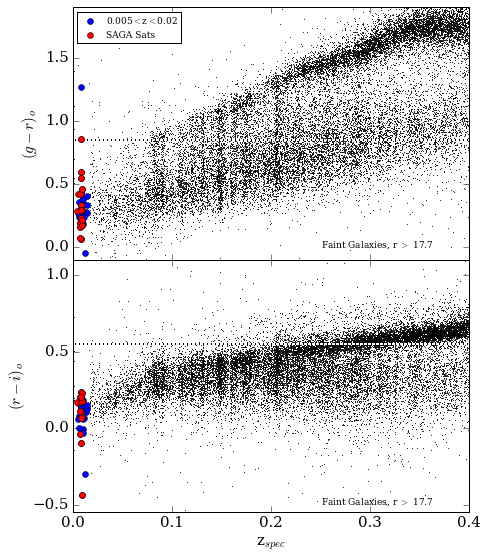

In [41]:
# AND THEN PLOT
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.rcParams['figure.figsize'] = 6, 6


########################################
ax1.plot(spec['SPEC_Z'][m],gr[m],'k.',ms=1,label='_nolegend_')

ax1.set_ylim(-0.1,1.9)
ax1.set_xlim(0,0.4)
ax1.set_ylabel('$(g-r)_o$')
ax1.plot([-10,10],[0.85,0.85],'w')
ax1.plot([-10,10],[0.85,0.85],'k:')

ax1.get_xaxis().set_ticklabels([])
ax1.plot(spec['SPEC_Z'][m_f & lowz], gr[m_f & lowz],'bo',label = '0.005$<$z$<$0.02')
ax1.plot(spec['SPEC_Z'][m_f & sats], gr[m_f & sats],'ro',label = 'SAGA Sats')
    
ax1.text(0.25,0,'Faint Galaxies, r $>$ 17.7',fontsize=9)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax1.legend(loc=2,fontsize=9,frameon=True,numpoints = 1)
   
    
    
########################################
ax2.plot(spec['SPEC_Z'][m],ri[m],'k.',ms=1)
ax2.plot(spec['SPEC_Z'][m_f & lowz], ri[m_f & lowz],'bo',label = '_nolegend_')
ax2.plot(spec['SPEC_Z'][m_f & sats], ri[m_f & sats],'ro',label = '_nolegend_')

ax2.set_ylim(-0.55,1.1)
ax2.set_xlim(0,0.4)
ax2.plot([-10,10],[0.55,0.55],'w',lw=2)
ax2.plot([-10,10],[0.55,0.55],'k:')

ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

ax2.text(0.25,-0.5,'Faint Galaxies, r $>$ 17.7',fontsize=9)

#ax2.xaxis.set_major_locator(0.2)

ax2.set_xlabel('z$_{spec}$')
ax2.set_ylabel('$(r-i)_o$')
plt.tight_layout(h_pad=0)
plt.savefig('fig_color2.pdf')


In [42]:
def add_outlier_errors(obj,ax):

    gmag = obj['g'] - obj['EXTINCTION_G']
    rmag = obj['r'] - obj['EXTINCTION_R']
    imag = obj['i'] - obj['EXTINCTION_I']

    gr = gmag - rmag
    ri = rmag - imag

    grerr = np.sqrt(obj['g_err']**2 + obj['r_err']**2)
    rierr = np.sqrt(obj['r_err']**2 + obj['i_err']**2)

    cgr = gr - 2.*grerr
    cri = ri - 2.*rierr

    msk1 = cgr > 0.85
    msk2 = cri > 0.55
    msk = msk1 | msk2
    print np.sum(msk)
    for ol in obj[msk]:
        print ol['SATS'],ol['RA'],ol['DEC'],ol['r']


    msk1 = gr > 0.85
    msk2 = ri > 0.55
    msk = msk1 | msk2
    
    if np.sum(msk) > 0:
        ax.errorbar(gr[msk],ri[msk],xerr=2.*grerr[msk],yerr=2.*rierr[msk],ecolor='#ffa500',capthick=0,fmt='.',label='_nolegend_')#,linewidth=2)

